## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

## Frequency Dataset

In [8]:
def generate_varying_freq_signal(min_freq, max_freq, sampling_freq, total_time):
    # Create an array of time points
    t = np.linspace(0, total_time, int(sampling_freq * total_time))

    # Linearly interpolate the frequency from min_freq to max_freq
    instantaneous_freq = np.linspace(min_freq, max_freq, len(t))

    # Integrate the instantaneous frequency to get the phase
    phase = np.cumsum(instantaneous_freq) / sampling_freq

    # Generate the signal
    signal = np.sin(2 * np.pi * phase)

    return t, signal, instantaneous_freq


def sliding_window_dataset(signal, t_sample, sampling_freq):
    # Calculate the number of points in each sample
    sample_points = int(t_sample * sampling_freq)

    # Calculate the total number of samples we can extract
    num_samples = len(signal) - sample_points + 1

    # Initialize the dataset
    data = np.zeros((num_samples, sample_points))

    # Apply the sliding window
    for i in range(num_samples):
        data[i] = signal[i:i + sample_points]
        
    data = np.reshape(data, (data.shape[0], data.shape[1], 1))

    return data


def deterministic_gaussian_sampling(signal, t, instantaneous_freq, mean_freq, std_freq, sampling_freq, window_size_seconds):
    # Calculate the number of points in each sample
    sample_points = int(window_size_seconds * sampling_freq)
    # Calculate the total number of samples to match what we would get from the sliding window approach (uniform distribution)
    num_samples = len(signal) - sample_points + 1
    
    # Define the Gaussian distribution over the frequency range
    x = np.linspace(min_freq, max_freq, len(instantaneous_freq))
    gaussian_pdf = stats.norm.pdf(x, mean_freq, std_freq)
    gaussian_cdf = np.cumsum(gaussian_pdf)
    gaussian_cdf /= gaussian_cdf[-1]  # Normalize to form a proper CDF

    # Sample indices using the inverse CDF
    random_values = np.linspace(0, 1, num_samples + 2)[1:-1]  # exclude exact 0 and 1 for stability
    sampled_indices = np.searchsorted(gaussian_cdf, random_values).astype(int)
    
    # Convert window size in seconds to number of samples
    window_size_samples = int(window_size_seconds * sampling_freq)

    # Dataset to store the samples
    data = np.zeros((num_samples, window_size_samples))

    for i, index in enumerate(sampled_indices):
        start_index = max(0, index - window_size_samples // 2)
        end_index = start_index + window_size_samples
        if end_index > len(signal):
            start_index = len(signal) - window_size_samples
            end_index = len(signal)
        data[i] = signal[start_index:end_index]

    # Reshape the dataset to add an extra dimension
    data = data.reshape(num_samples, window_size_samples, 1)

    return data

#### Gaussian distribution

In [9]:
# Parameters
min_freq = 10  # Hz
max_freq = 80  # Hz
total_time = 10  # seconds
max_points_per_cycle = 100
mean_freq = 50  # Hz
std_freq = 10  # Hz
#num_samples = 99001
sampling_freq = max_points_per_cycle * min_freq  # Hz
t_sample = 1.  # seconds

# Generate the signal
t, signal, instantaneous_freq = generate_varying_freq_signal(min_freq, max_freq, sampling_freq, total_time)

# Generate the dataset using deterministic Gaussian sampling
data = deterministic_gaussian_sampling(signal, t, instantaneous_freq, mean_freq, std_freq, sampling_freq, t_sample)
data.shape

(9001, 1000, 1)

#### Uniform distribution

In [28]:
# Parameters
min_freq = 10  # Hz
max_freq = 80 # Hz
total_time = 100 # seconds
max_points_per_cycle = 100
sampling_freq = max_points_per_cycle * min_freq   # Calculate the sampling frequency such that 20 timepoints correspond to a full cycle at the lowest frequency
t_sample = 1  # seconds, window size

# Generate the signal
t, signal, instantaneous_freq = generate_varying_freq_signal(min_freq, max_freq, sampling_freq, total_time)

# Generate the dataset using sliding window (uniform distribution)
data = sliding_window_dataset(signal, t_sample, sampling_freq)
data.shape

(99001, 1000, 1)

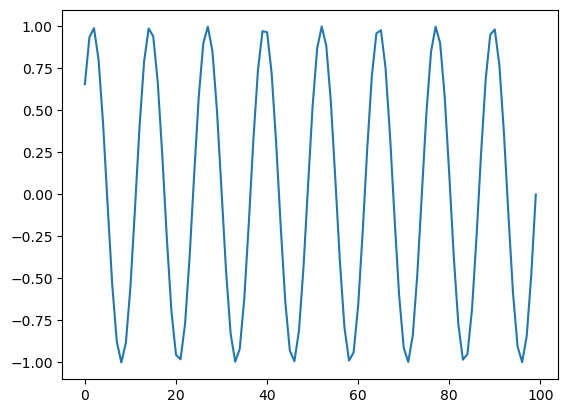

In [10]:
plt.plot(signal[-100:])

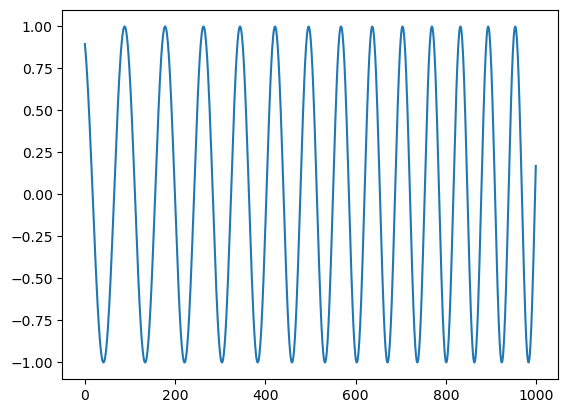

In [11]:
plt.plot(data[0])

### Data Loader

In [12]:
def create_dataloader(data, batch_size=256, reshuffle_after_epoch=True):
    '''
    Creates a DataLoader for Pytorch to train the autoencoder with the image data converted to a tensor.

    Args:
        dataset (4D numpy array): image dataset with shape (n_samples, n_channels, n_pixels_height, n_pixels_width).
        batch_size (int; default=32): the size of the batch updates for the autoencoder training.

    Returns:
        DataLoader (Pytorch DataLoader): dataloader that is ready to be used for training an autoencoder.
    '''
    if data.shape[-1] == 1:
        data = np.transpose(data, (0,2,1))
    tensor_dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(data).float())
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=reshuffle_after_epoch)

In [13]:
dataset = create_dataloader(data, batch_size=256, reshuffle_after_epoch=True)

## Autoencoder

In [14]:
class ConvAE(nn.Module):
    def __init__(self, n_hidden=100, sample_length=1000, kernel_size=100):
        super().__init__()

        self.n_hidden = n_hidden
        self.kernel_size=kernel_size

        # Encoder
        self.conv1 = nn.Conv1d(1, 16, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2, padding=1)
        
        # Hidden layer
        self.flattened_size = self.calculate_flattened_size(sample_length, kernel_size)
        self.fc1 = nn.Linear(64 * self.flattened_size, n_hidden)

        # Decoder
        self.fc2 = nn.Linear(n_hidden, 64 * self.flattened_size)
        self.conv4 = nn.ConvTranspose1d(64, 32, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)
        self.conv5 = nn.ConvTranspose1d(32, 16, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)
        self.conv6 = nn.ConvTranspose1d(16, 1, kernel_size=kernel_size, stride=2, padding=1, output_padding=0)

    def calculate_flattened_size(self, sample_length, kernel_size):
        size_after_conv1 = (sample_length - kernel_size + 2 * 1) // 2 + 1
        size_after_conv2 = (size_after_conv1 - kernel_size + 2 * 1) // 2 + 1
        size_after_conv3 = (size_after_conv2 - kernel_size + 2 * 1) // 2 + 1
        return size_after_conv3

    def encoder(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * self.flattened_size)
        x = F.relu(self.fc1(x))
        return x

    def decoder(self, x):
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, self.flattened_size)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.tanh(self.conv6(x))
        return x

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

    def backward(self, optimizer, criterion, x, y_true, alpha=0):
        optimizer.zero_grad()
        y_pred, hidden = self.forward(x)
        recon_loss = criterion(y_pred, y_true)

        whitening_loss = 0
        batch_size, hidden_dim = hidden.shape
        if alpha != 0:
            C = torch.eye(hidden_dim, device='cuda') - torch.mm(hidden.t(), hidden)
            whitening_loss = alpha * torch.norm(C) / (batch_size*hidden_dim)
        
        loss = recon_loss + whitening_loss
        loss.backward()
        optimizer.step()
        
        return recon_loss.item()

In [15]:
# Create an instance of the autoencoder
model = ConvAE(n_hidden=100, sample_length=data.shape[1], kernel_size=max_points_per_cycle)

### Train

In [16]:
def train_autoencoder(model, train_loader, num_epochs=1000, learning_rate=1e-3, alpha=0):
    """
    Train the autoencoder model.
    :param model: Autoencoder model.
    :param dataloader: DataLoader for the training data.
    :param epochs: Number of training epochs.
    :param learning_rate: Learning rate for the optimizer.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to('cuda')
    history = []
    for epoch in range(num_epochs):
        running_loss = 0
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader, 0):
                inputs, _ = data
                inputs = inputs.to('cuda')

                loss = model.backward(optimizer=optimizer, criterion=criterion, x=inputs, y_true=inputs, alpha=alpha)
                running_loss += loss

                pbar.update(1)
                pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

        history.append(running_loss/len(train_loader))
        
    return history

In [12]:
history = train_autoencoder(model, dataset, num_epochs=1000, learning_rate=1e-4, alpha=1e4)

Epoch 128/1000, Loss: 0.0258: 100%|██████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 58.65it/s]


Epoch 256/1000, Loss: 0.0171: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 70.07it/s]


Epoch 384/1000, Loss: 0.0139: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 68.06it/s]


Epoch 512/1000, Loss: 0.0114: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 68.27it/s]


Epoch 640/1000, Loss: 0.0108: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 75.64it/s]


Epoch 768/1000, Loss: 0.0102: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 66.73it/s]


Epoch 896/1000, Loss: 0.0102: 100%|██████████████████████████████████████████████████████████| 387/387 [00:05<00:00, 71.37it/s]


Epoch 1000/1000, Loss: 0.0092: 100%|█████████████████████████████████████████████████████████| 387/387 [00:04<00:00, 77.42it/s]


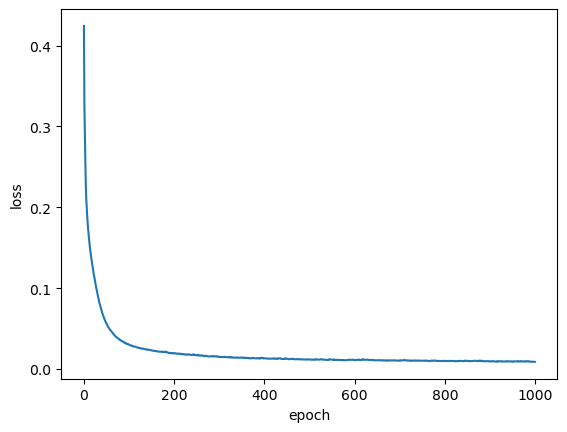

In [188]:
plt.plot(history)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [189]:
#torch.save(model, 'saved_models/AEfreq_hidden1e2_kernel1e2_lr1e-4_epochs1e3_alpha1e4.pth')

In [12]:
model = torch.load('saved_models/AEfreq_hidden1e2_kernel1e2_lr1e-4_epochs1e3_alpha1e4.pth')

In [17]:
def predict(sample, model):
    '''
    Returns the output of model(image), and reshapes it to be compatible with plotting funtions such as plt.imshow().

    Args:
        sample (3D numpy array): sample with shape (n_channels, n_timepoints).
        model (Pytorch Module): convolutional autoencoder that is prepared to process images such as 'image'.

    Returns:
        output_sample (3D numpy array): output timeseries with shape (n_timepoints, n_channels)
    '''
    if sample.shape[-1] <= 4:
        sample = np.transpose(sample, (1,0))
    n_channels, n_timepoints = sample.shape
    sample = np.reshape(sample, (1, n_channels, n_timepoints))
    sample = torch.from_numpy(sample).float().to(next(model.parameters()).device)
    output_sample = model(sample)[0].detach().cpu().numpy()
    output_sample = np.reshape(output_sample, (n_channels, n_timepoints))
    output_sample = np.transpose(output_sample, (1,0))
    return output_sample

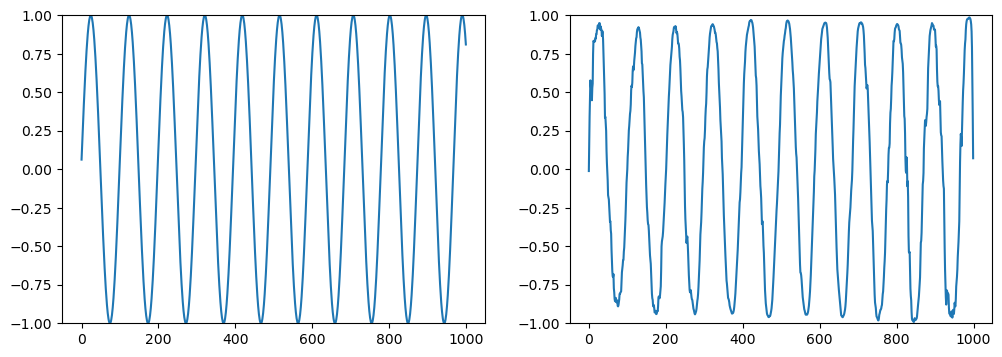

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(data[0])
plt.ylim(-1,1)

plt.subplot(122)
plt.plot(predict(data[0], model))
plt.ylim(-1,1)

plt.show()

## Frequency receptive field analysis

In [18]:
def create_test_dataset(freq_range, delta_freq, sample_length):
    """
    Build a test dataset with samples at different frequencies.
    Args:
        min_freq (float): Minimum frequency.
        max_freq (float): Maximum frequency.
        delta_freq (float): Frequency resolution.
        sample_length (int): Length of each sample.
    Returns:
        torch.Tensor: Test dataset.
    """
    frequencies = np.arange(freq_range[0], freq_range[1], delta_freq)
    test_dataset = []
    for freq in frequencies:
        t = np.linspace(0, 1, sample_length, endpoint=False)
        sample = np.sin(2 * np.pi * freq * t)
        test_dataset.append(sample)
    test_dataset = np.reshape(test_dataset, (len(test_dataset), len(test_dataset[0]), 1))
    return test_dataset

In [19]:
def clean_embeddings(embeddings):
    '''
    Takes only the embeddings that are active an any given point, and, if normalize=True, normalizes the values.

    Args:
        embeddings (2D numpy array): 2D matrix latent embeddings through time, with shape (n_samples, n_latent).
        normalize (bool; default=False): if True, the embedding activation values will be normalized to [-1,1], per each unit.

    Returns:
        embeddings_clean (2D numpy array): original embeddings matrix, with the silent units removed, with shape (n_samples, n_active).
    '''
    indxs_active = np.any(embeddings, axis=0)
    n_active = np.sum(indxs_active)
    embeddings_clean = embeddings[:,indxs_active]
    return embeddings_clean

In [20]:
def get_embeddings(dataset, model, batch_size=256):
    '''
    Returns the latent activation vectors of the autoencoder model after passing all the images in the dataset.

    Args:
        dataset (numpy array): image dataset with shape 
        model (Pytorch Module): convolutional autoencoder that is prepared to process the images in dataset.

    Returns:
        latent_vectors (2D numpy array): latent activation vectors, matrix with shape (n_samples, n_hidden), where n_hidden is the number of units in the hidden layer.
    '''
    if dataset.shape[-1] == 1:
        dataset = np.transpose(dataset, (0,2,1))
    tensor_dataset = TensorDataset(torch.from_numpy(dataset).float(), torch.from_numpy(dataset).float())
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, _ = batch
            latent = model(inputs.to('cuda'))[1]
            latent_vectors.append(latent.cpu().numpy())
    latent_vectors = np.concatenate(latent_vectors)
    return latent_vectors

In [21]:
test_dataset = create_test_dataset(freq_range=(min_freq, max_freq), delta_freq=0.01, sample_length=data.shape[1])

In [20]:
hidden_activations = clean_embeddings(get_embeddings(test_dataset, model))

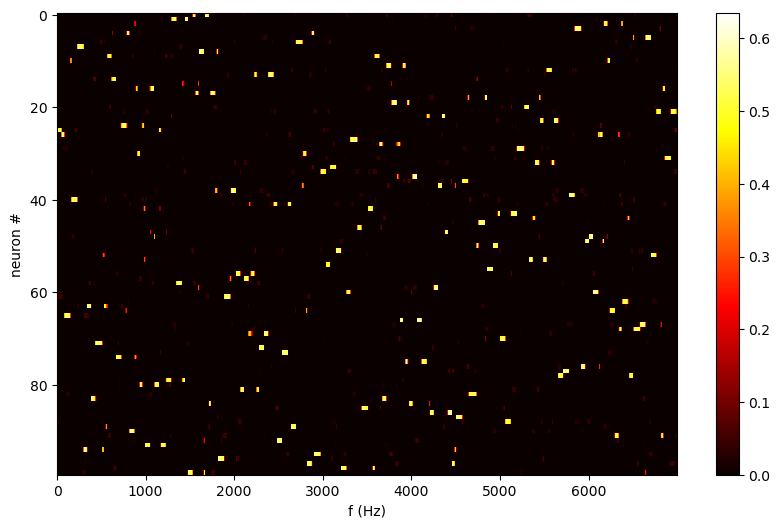

In [21]:
plt.figure(figsize=(10,6))

plt.imshow(hidden_activations.T, aspect='auto', cmap='hot', origin='upper', interpolation='none')

plt.colorbar()

plt.xlabel('f (Hz)')
plt.ylabel('neuron #')
plt.show()

In [22]:
def normalize_and_reorder(arr):
    """
    This function takes a 2D numpy array and performs two operations:
    1. Normalizes each row of the array based on its maximum value.
    2. Reorders the rows based on the index of the peak (maximum) value in each row.

    Parameters:
    arr (numpy.ndarray): The input 2D numpy array.

    Returns:
    numpy.ndarray: The processed 2D numpy array.
    """
    # Normalize each row by its maximum value
    row_maxes = np.max(arr, axis=1).reshape(-1, 1)
    normalized_arr = arr / row_maxes

    # Find the index of the maximum value in each row
    peak_indices = np.argmax(normalized_arr, axis=1)

    # Reorder the rows based on the peak indices
    sorted_indices = np.argsort(peak_indices)
    reordered_arr = normalized_arr[sorted_indices]

    return reordered_arr

In [23]:
np.linspace(min_freq, max_freq, 5)

array([10. , 27.5, 45. , 62.5, 80. ])

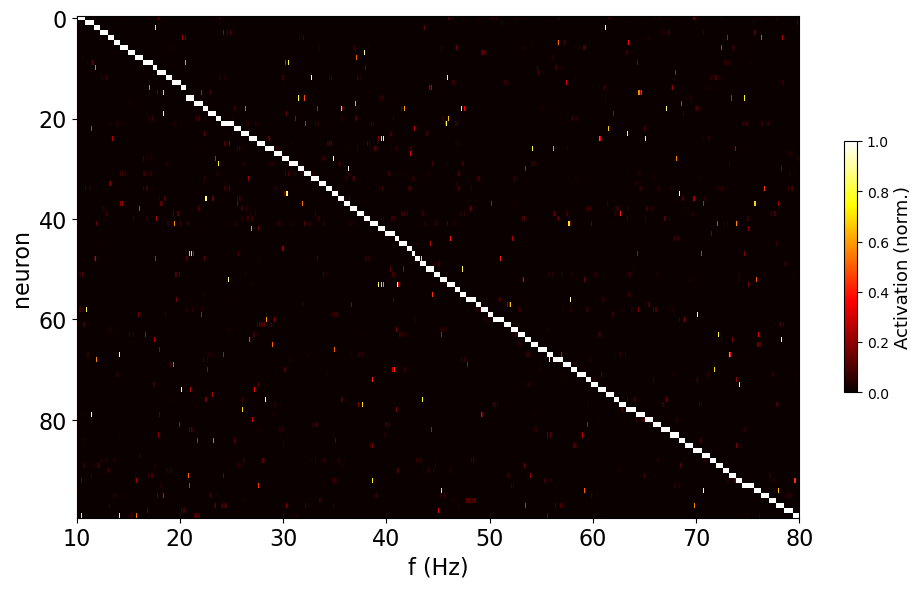

In [24]:
plt.figure(figsize=(10,6))

sorted_hidden_activation = normalize_and_reorder(hidden_activations).T

plt.imshow(sorted_hidden_activation, aspect='auto', cmap='hot', origin='upper', interpolation='none')

plt.colorbar(shrink=0.5).set_label(label='Activation (norm.)',size=13)

plt.xlabel('f (Hz)', fontsize=16)
plt.ylabel('neuron', fontsize=16)
plt.xticks(np.linspace(0, test_dataset.shape[0]-1, 8), np.linspace(min_freq, max_freq, 8).astype(int), fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('freq_fields-ortho.png', dpi=600)

plt.show()

In [29]:
model_ortho = torch.load('saved_models/AEfreq_hidden1e2_kernel1e2_lr1e-4_epochs1e3_alpha1e4.pth')
model_nonortho = torch.load('saved_models/AEfreq_hidden1e2_kernel1e2_lr1e-4_epochs1e3_alpha0.pth')

hidden_activations_ortho = clean_embeddings(get_embeddings(test_dataset, model_ortho))
hidden_activations_nonortho = clean_embeddings(get_embeddings(test_dataset, model_nonortho))

sorted_hidden_activation_ortho = normalize_and_reorder(hidden_activations_ortho).T
sorted_hidden_activation_nonortho = normalize_and_reorder(hidden_activations_nonortho).T

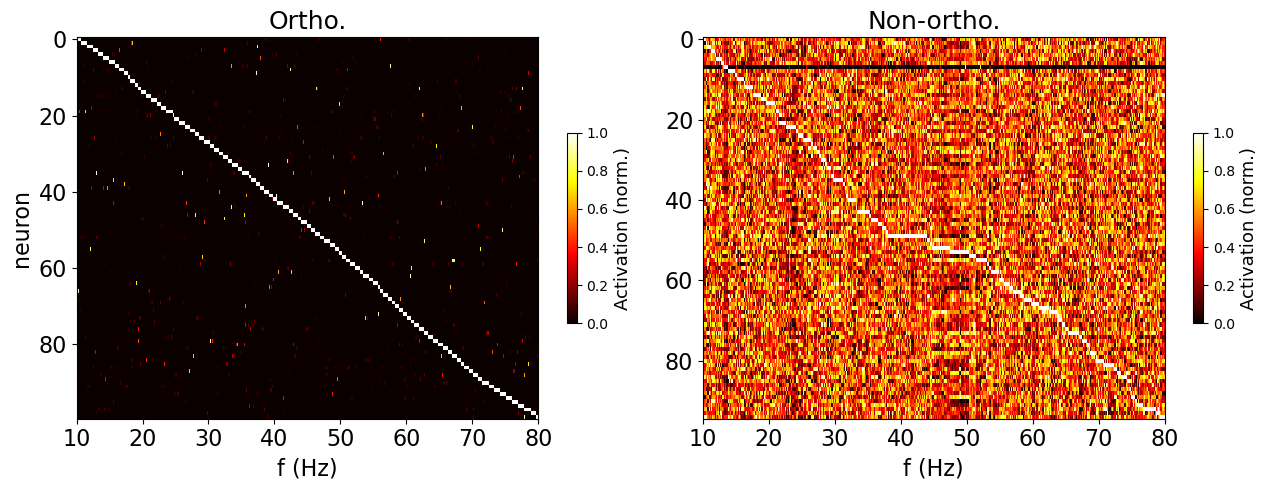

In [18]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)

plt.imshow(sorted_hidden_activation_ortho, aspect='auto', cmap='hot', origin='upper', interpolation='none')

plt.title('Ortho.', fontsize=18)
plt.colorbar(shrink=0.5).set_label(label='Activation (norm.)',size=13)

plt.xlabel('f (Hz)', fontsize=16)
plt.ylabel('neuron', fontsize=16)
plt.xticks(np.linspace(0, test_dataset.shape[0]-1, 8), np.linspace(min_freq, max_freq, 8).astype(int), fontsize=16)
plt.yticks(fontsize=16)


plt.subplot(1,2,2)

plt.imshow(sorted_hidden_activation_nonortho, aspect='auto', cmap='hot', origin='upper', interpolation='none')

plt.title('Non-ortho.', fontsize=18)
plt.colorbar(shrink=0.5).set_label(label='Activation (norm.)',size=13)

plt.xlabel('f (Hz)', fontsize=16)
#plt.ylabel('neuron', fontsize=16)
plt.xticks(np.linspace(0, test_dataset.shape[0]-1, 8), np.linspace(min_freq, max_freq, 8).astype(int), fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('freq_fields.png', dpi=600)

plt.show()

In [23]:
def extract_feature_images(model, embeddings, clamping_value=None):
    '''
    TO DO. Choice of the appropriate clamping value to be fixed --> mean doesn't seem to work well.
    '''
    indxs_active = np.arange(embeddings.shape[1])[np.any(embeddings, axis=0)]
    images = []
    for i in np.arange(model.n_hidden):
        if i in indxs_active:
            input_ = torch.zeros(model.n_hidden).to('cuda')
            activations = torch.tensor(embeddings[:,i])
            clamp_value = torch.mean(activations[torch.nonzero(activations)])
            if clamping_value != None:
                clamp_value = clamping_value
            input_[i] = clamp_value
            img = model.decoder(input_)[0].detach().cpu().numpy().T
            images.append(img)
        else:
            img = np.zeros(input_dims)
            images.append(img)
    images = np.array(images)
    
    return images

In [39]:
clamping_value = np.mean(np.max(hidden_activations, axis=0))

In [40]:
clamping_value

0.5571201

In [41]:
features = extract_feature_images(model, hidden_activations, clamping_value=0.557)

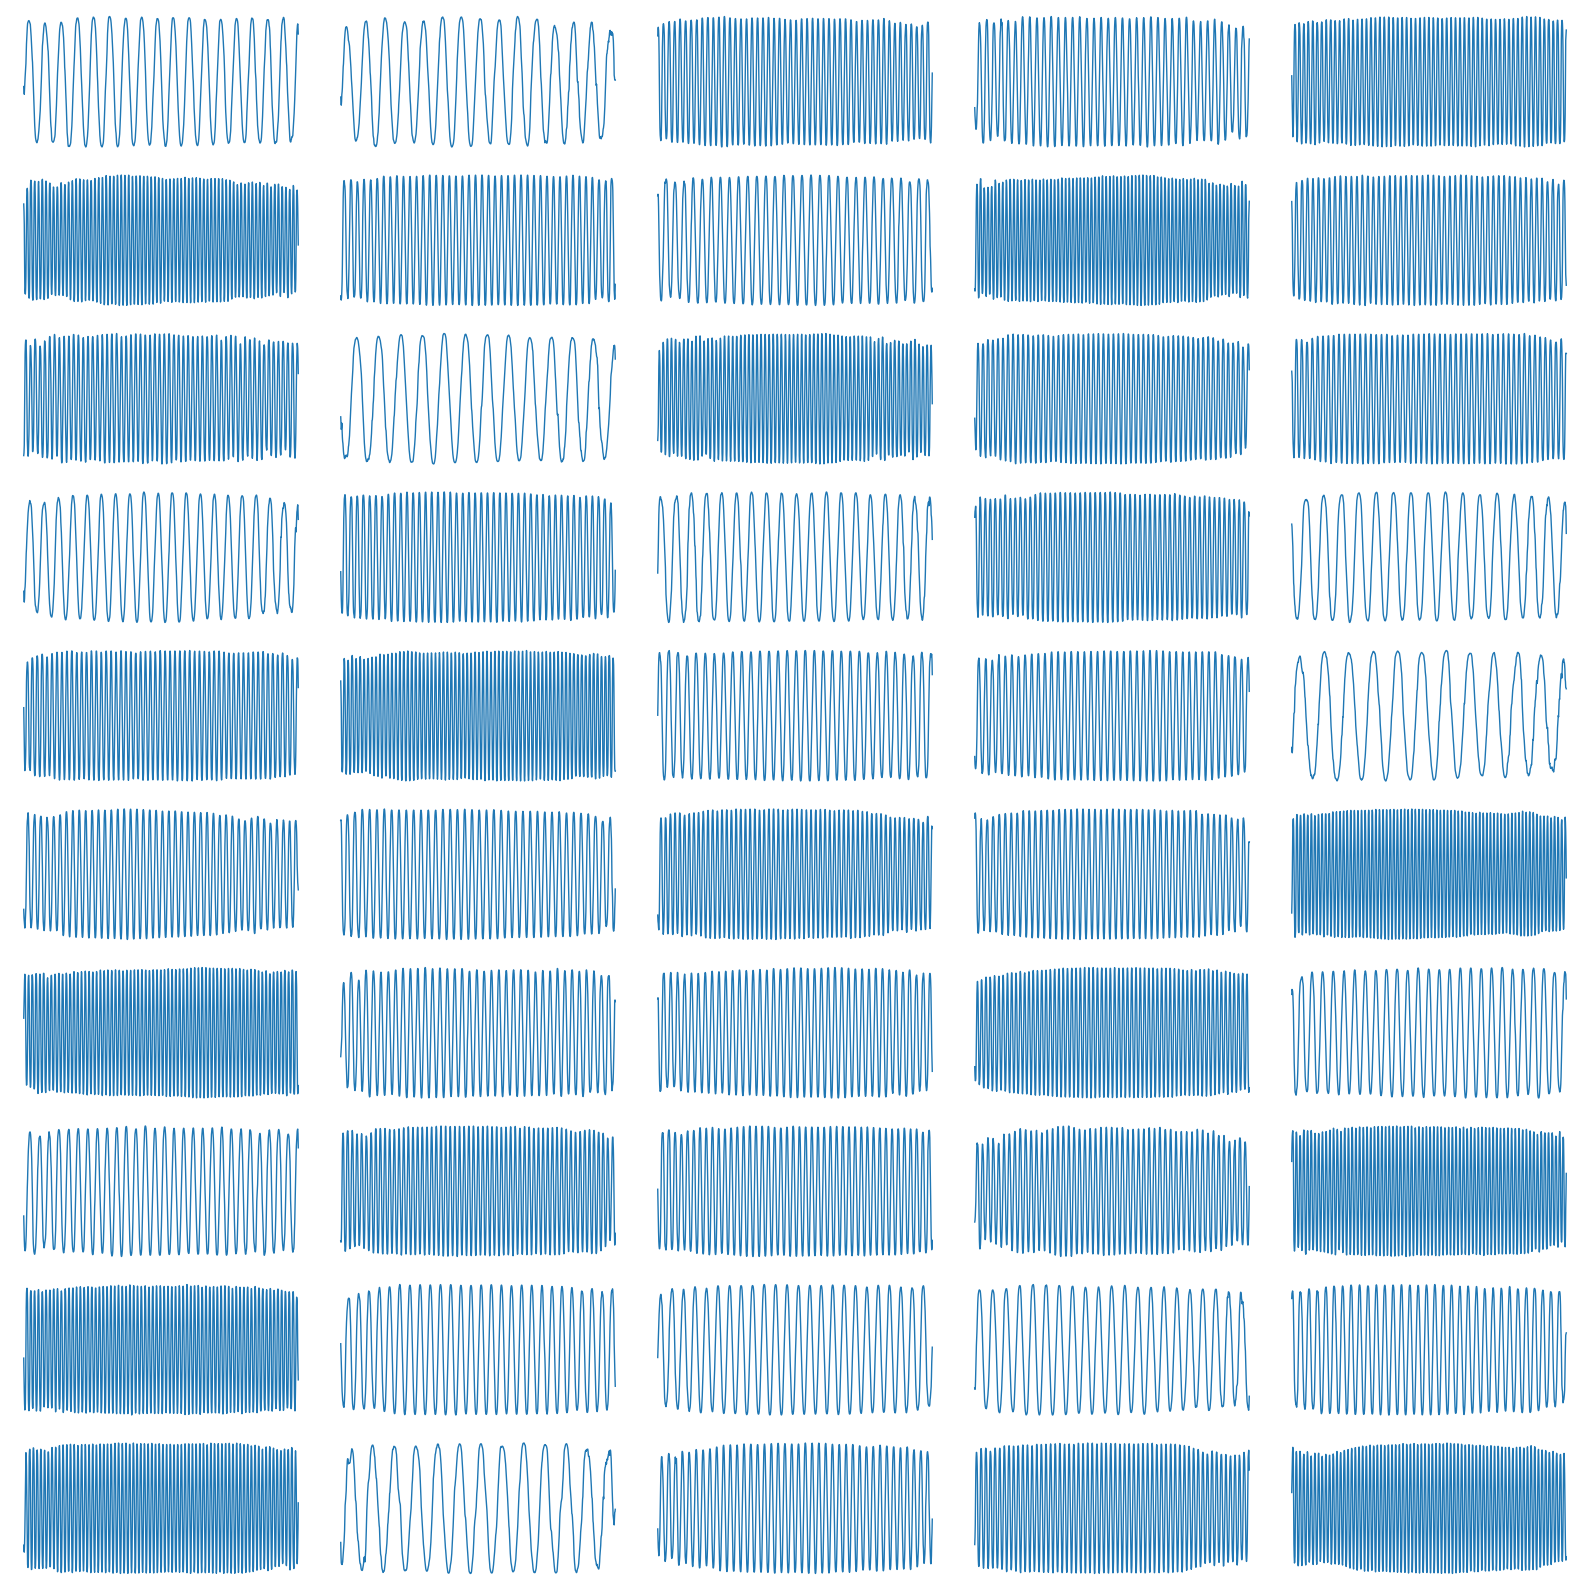

In [100]:
plt.figure(figsize=(16,16))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.plot(features[i].flatten(), linewidth=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Biased dataset

Density and size of receptive fields should change due to either overexposure to reward zone (more time spent there) or reward-prioritized replay.

In [32]:
n_samples = data.shape[0]
start_bias_freq = 40 
end_bias_freq = 50 
start_bias = int( ( (start_bias_freq - min_freq) / (max_freq - min_freq) ) * n_samples )
end_bias = int ( ( (end_bias_freq - min_freq) / (max_freq - min_freq) ) * n_samples )

'''
data_biased = np.concatenate((data, data[start_bias:end_bias], data[start_bias:end_bias], data[start_bias:end_bias],
                              data[start_bias:end_bias], data[start_bias:end_bias], data[start_bias:end_bias]), axis=0)
'''

'\ndata_biased = np.concatenate((data, data[start_bias:end_bias], data[start_bias:end_bias], data[start_bias:end_bias],\n                              data[start_bias:end_bias], data[start_bias:end_bias], data[start_bias:end_bias]), axis=0)\n'

In [21]:
#dataset_biased = create_dataloader(data_biased, batch_size=256, reshuffle_after_epoch=True)

In [25]:
dataset_biased = create_dataloader(data, batch_size=256, reshuffle_after_epoch=True)

In [27]:
# Create an instance of the autoencoder
model_biased = ConvAE(n_hidden=100, sample_length=data.shape[1], kernel_size=max_points_per_cycle)

In [28]:
history = train_autoencoder(model_biased, dataset_biased, num_epochs=1000, learning_rate=1e-4, alpha=1e4)

Epoch 64/1000, Loss: 0.1597: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 74.27it/s]


Epoch 128/1000, Loss: 0.1347: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.14it/s]


Epoch 192/1000, Loss: 0.1176: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.47it/s]


Epoch 256/1000, Loss: 0.1020: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.83it/s]


Epoch 320/1000, Loss: 0.0918: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 78.22it/s]


Epoch 384/1000, Loss: 0.0820: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.40it/s]


Epoch 448/1000, Loss: 0.0759: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 75.88it/s]


Epoch 512/1000, Loss: 0.0681: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 75.70it/s]


Epoch 576/1000, Loss: 0.0629: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.76it/s]


Epoch 640/1000, Loss: 0.0594: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 76.23it/s]


Epoch 704/1000, Loss: 0.0553: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 74.93it/s]


Epoch 768/1000, Loss: 0.0516: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 75.98it/s]


Epoch 832/1000, Loss: 0.0494: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.30it/s]


Epoch 896/1000, Loss: 0.0456: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.82it/s]


Epoch 960/1000, Loss: 0.0431: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 77.15it/s]


Epoch 1000/1000, Loss: 0.0414: 100%|███████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 73.92it/s]


In [33]:
hidden_activations_biased = clean_embeddings(get_embeddings(test_dataset, model_biased))
sorted_hidden_activation_biased = normalize_and_reorder(hidden_activations_biased).T

C:\Users\Afernandez\AppData\Local\Temp\ipykernel_23512\424130131.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_arr = arr / row_maxes


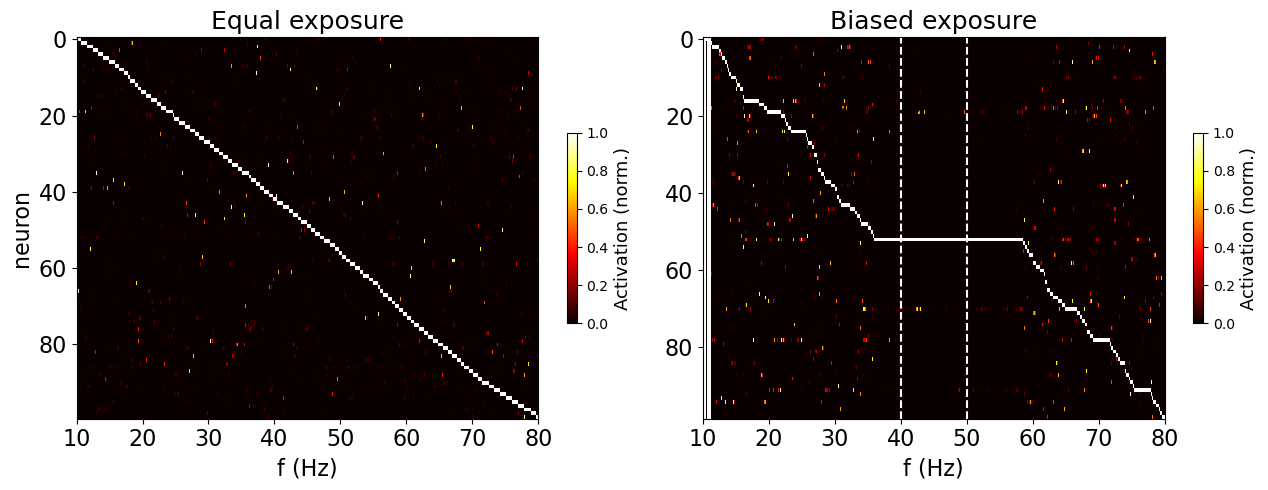

In [34]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)

plt.imshow(sorted_hidden_activation_ortho, aspect='auto', cmap='hot', origin='upper', interpolation='none')

plt.title('Equal exposure', fontsize=18)
plt.colorbar(shrink=0.5).set_label(label='Activation (norm.)',size=13)

plt.xlabel('f (Hz)', fontsize=16)
plt.ylabel('neuron', fontsize=16)
plt.xticks(np.linspace(0, test_dataset.shape[0]-1, 8), np.linspace(min_freq, max_freq, 8).astype(int), fontsize=16)
plt.yticks(fontsize=16)


plt.subplot(1,2,2)

plt.imshow(sorted_hidden_activation_biased, aspect='auto', cmap='hot', origin='upper', interpolation='none')

start_line = int( ( (start_bias_freq - min_freq) / (max_freq - min_freq) ) * test_dataset.shape[0] )
end_line = int ( ( (end_bias_freq - min_freq) / (max_freq - min_freq) ) * test_dataset.shape[0] )

plt.axvline(x=start_line, c="w", linestyle='--')
plt.axvline(x=end_line, c="w", linestyle='--')

pos_text = (start_line + end_line)/4
plt.text(x=pos_text, y=20, s='Overexposed zone', fontsize=10)

plt.title('Biased exposure', fontsize=18)
plt.colorbar(shrink=0.5).set_label(label='Activation (norm.)',size=13)

plt.xlabel('f (Hz)', fontsize=16)
#plt.ylabel('neuron', fontsize=16)
plt.xticks(np.linspace(0, test_dataset.shape[0]-1, 8), np.linspace(min_freq, max_freq, 8).astype(int), fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()

#plt.savefig('freq_fields_overexposed.png', dpi=600)

plt.show()